# Introduction

After the COVID pandemic, one of the hottest topics became the food prices in the world. All over the world, rapid inflation has affected food prices enormously and even the effects are higher in Turkey. From November 2021 to November 2022, food prices increased by 102.6%(1), one of the highest increases around the world. As a fundamental part of human life, predicting what will happen to food prices is crucial to maintaining human life.

In this homework, the main project is to forecast the food and non-alcoholic drink consumer price index. Interest rates(2-14 days) and unemployment rate are used as regressors. Relation between regressors and response variable are explained by;

- **Interest rates(2-14 days)**: As the CPI for food and non-alcoholic beverages is a measure of inflation, one of the first things that comes to mind is the interest rate. As two of the most important measures to understand a country's situation, these factors are interrelated in an indirect way. Countries use interest rates to control inflation. In this homework, it is assumed that instead of consuming food, people can save their money in their pockets. The interest rate(2-14 days) is the measure of the benefit of not spending money. 
- **Unemployment Rate**: The Philips curve explains the relationship between unemployment and inflation rate in the short term. In summary, an increase in unemployment also triggers an increase in inflation, and vice versa. There are other viewpoints on these factors in the long term but the Philips curve is a widely accepted concept. 

Also, the relation between these two regressors of the main model is explained by the fact that when interest rates increase, businesses tend to stop taking loans and in the end, potentially job openings decrease.

In the rest of the homework, three forecast models are built by time series regression. Each of the factors is used as the response variable while the other ones are regressors. To increase the accuracy and reliability of the models, additional regressors are added from Google Trends data.

(1)[Inflation rate for food in Turkey from July 2022 to January 2024 [Graph], Trading Economics, February 13, 2024. [Online]. Available: https://www.statista.com/statistics/1398698/turkey-inflation-rate-for-food/.](https://www.statista.com/statistics/1398698/turkey-inflation-rate-for-food/)

# Code

### Imports

In [178]:
import pandas as pd # to read data and handle dataframe
import matplotlib.pyplot as plt # to plot graphs
import statsmodels.api as sm # to build the model
from sklearn.preprocessing import MinMaxScaler # to scale the data
from sklearn.model_selection import train_test_split # to split the data into train and test
import numpy as np # to do mathematical operations


### Data Preprocessing

In [179]:
bank_data_loc = "Data\EVDS Data.xlsx"

# Read the data
df_bank = pd.read_excel(bank_data_loc)
df_bank = df_bank[:-23] # remove the last 23 rows which are not data

# All of the EVDS data
df_bank.head()

,Tarih,TP YISGUCU2 G4,TP API REP ORT G214,TP FG J01
0,2015-01,3375,8.23,282.23
1,2015-02,3362,7.88,289.53
2,2015-03,3019,7.77,296.69
3,2015-04,2796,8.3,301.53
4,2015-05,2626,8.37,293.44


In [180]:
cigkofte_data_loc = "Data\cigkofte.csv"
faiz_orani_data_loc = "Data\mfaiz_orani.csv"
yemeksepeti_data_loc = "Data\yemeksepeti.csv"
kariyernet_data_loc = "Data\kariyer.net.csv"
is_ilani_data_loc = "Data\is_ilanı.csv"
tcmb_faiz_orani_loc = "Data\TCMB_faiz_orani.csv"
kredi_kart_borcu_loc = "Data\kredi_karti_borcu.csv"

# Read all of the data
cigkofte_df = pd.read_csv(cigkofte_data_loc, skiprows=1) # skip the first row which is the column name
faiz_df = pd.read_csv(faiz_orani_data_loc, skiprows=1)
yemeksepeti_df = pd.read_csv(yemeksepeti_data_loc, skiprows=1)
kariyernet_df = pd.read_csv(kariyernet_data_loc, skiprows=1)
is_ilani_df = pd.read_csv(is_ilani_data_loc, skiprows=1)
tcmb_faiz_orani_df = pd.read_csv(tcmb_faiz_orani_loc, skiprows=1)
kredi_kart_borcu_df = pd.read_csv(kredi_kart_borcu_loc, skiprows=1)

# Combine all of the dataframes
merged_df = pd.merge(cigkofte_df, faiz_df, on='Ay')
merged_df = pd.merge(merged_df, yemeksepeti_df, on='Ay')
merged_df = pd.merge(merged_df, kariyernet_df, on='Ay')
merged_df = pd.merge(merged_df, is_ilani_df, on='Ay')
merged_df = pd.merge(merged_df, tcmb_faiz_orani_df, on='Ay')
merged_df = pd.merge(merged_df, kredi_kart_borcu_df, on='Ay')

merged_df["Tarih"] = merged_df["Ay"]
merged_df.drop("Ay", axis=1, inplace=True)

# All of the Google Trends data
merged_df.head() 

,çiğköfte: (Türkiye),faiz oranı: (Türkiye),yemeksepeti: (Türkiye),kariyer.net: (Türkiye),iş ilanı: (Türkiye),TCMB Faiz Oranı: (Türkiye),kredi kartı borcu: (Türkiye),Tarih
0,23,13,58,92,47,0,39,2015-01
1,24,13,56,100,59,0,39,2015-02
2,23,11,54,97,46,0,43,2015-03
3,22,10,48,86,49,0,40,2015-04
4,21,11,56,76,49,30,36,2015-05


In [181]:
df = pd.merge(df_bank, merged_df, on='Tarih') # merge the EVDS data with Google Trends data
df.columns = ["Date", "Unemployement", "Interest(2-14 days)", "Food Price Index", "Cigkofte", "Faiz_Orani", "Yemeksepeti", "Kariyer.net", "Is_ilani", "TCMB Faiz Orani", "Kredi Karti Borcu"]
df.index = df["Date"]
df.drop("Date", axis=1, inplace=True)

# All of the data
df.head()

,Unemployement,Interest(2-14 days),Food Price Index,Cigkofte,Faiz_Orani,Yemeksepeti,Kariyer.net,Is_ilani,TCMB Faiz Orani,Kredi Karti Borcu
Date,,,,,,,,,,
2015-01,3375,8.23,282.23,23,13,58,92,47,0,39
2015-02,3362,7.88,289.53,24,13,56,100,59,0,39
2015-03,3019,7.77,296.69,23,11,54,97,46,0,43
2015-04,2796,8.3,301.53,22,10,48,86,49,0,40
2015-05,2626,8.37,293.44,21,11,56,76,49,30,36


In [182]:
# To see the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 2015-01 to 2023-12
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unemployement        108 non-null    object 
 1   Interest(2-14 days)  108 non-null    object 
 2   Food Price Index     108 non-null    float64
 3   Cigkofte             108 non-null    int64  
 4   Faiz_Orani           108 non-null    int64  
 5   Yemeksepeti          108 non-null    int64  
 6   Kariyer.net          108 non-null    int64  
 7   Is_ilani             108 non-null    int64  
 8   TCMB Faiz Orani      108 non-null    int64  
 9   Kredi Karti Borcu    108 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 9.3+ KB


In [183]:
# Convert the object type columns to float
df["Unemployement"] = df["Unemployement"].astype(float) 
df["Interest(2-14 days)"] = df["Interest(2-14 days)"].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 2015-01 to 2023-12
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unemployement        108 non-null    float64
 1   Interest(2-14 days)  108 non-null    float64
 2   Food Price Index     108 non-null    float64
 3   Cigkofte             108 non-null    int64  
 4   Faiz_Orani           108 non-null    int64  
 5   Yemeksepeti          108 non-null    int64  
 6   Kariyer.net          108 non-null    int64  
 7   Is_ilani             108 non-null    int64  
 8   TCMB Faiz Orani      108 non-null    int64  
 9   Kredi Karti Borcu    108 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 9.3+ KB


In [184]:
# To see the statistical information of the data
df.describe()

,Unemployement,Interest(2-14 days),Food Price Index,Cigkofte,Faiz_Orani,Yemeksepeti,Kariyer.net,Is_ilani,TCMB Faiz Orani,Kredi Karti Borcu
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,3624.953704,14.010648,727.846389,52.481481,29.453704,59.259259,44.444444,57.935185,31.842593,31.750000
std,500.031875,6.313122,594.988228,19.770402,15.154275,14.402343,21.375737,13.689667,24.760597,11.934498
min,2626.000000,7.640000,282.230000,18.000000,10.000000,34.000000,15.000000,30.000000,0.000000,18.000000
25%,3253.250000,8.837500,344.375000,35.750000,15.000000,48.000000,25.000000,48.000000,0.000000,25.000000
50%,3576.000000,12.250000,489.265000,55.000000,30.000000,57.000000,43.000000,56.000000,35.000000,29.000000
75%,3979.750000,17.402500,715.182500,69.000000,38.000000,71.000000,55.500000,65.000000,47.000000,35.250000
max,4830.000000,40.560000,2675.310000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [185]:
scaler = MinMaxScaler() # to scale the data

# Scale all data to 0-100, like the Google Trends data
df["Unemployement"] = scaler.fit_transform(df["Unemployement"].values.reshape(-1,1)) * 100
df["Interest(2-14 days)"] = scaler.fit_transform(df["Interest(2-14 days)"].values.reshape(-1,1)) * 100
df["Food Price Index"] = scaler.fit_transform(df["Food Price Index"].values.reshape(-1,1)) * 100
df["Trend"] = range(1, len(df) + 1) # to create a trend column

df.head()

,Unemployement,Interest(2-14 days),Food Price Index,Cigkofte,Faiz_Orani,Yemeksepeti,Kariyer.net,Is_ilani,TCMB Faiz Orani,Kredi Karti Borcu,Trend
Date,,,,,,,,,,,
2015-01,33.983666,1.792224,0.000000,23,13,58,92,47,0,39,1
2015-02,33.393829,0.729040,0.305046,24,13,56,100,59,0,39,2
2015-03,17.831216,0.394897,0.604242,23,11,54,97,46,0,43,3
2015-04,7.713249,2.004860,0.806492,22,10,48,86,49,0,40,4
2015-05,0.000000,2.217497,0.468434,21,11,56,76,49,30,36,5


In [186]:
# To see the correlation between the columns
df.corr()

,Unemployement,Interest(2-14 days),Food Price Index,Cigkofte,Faiz_Orani,Yemeksepeti,Kariyer.net,Is_ilani,TCMB Faiz Orani,Kredi Karti Borcu,Trend
Unemployement,1.000000,0.282923,-0.146586,0.458015,0.536186,0.444277,-0.138176,0.468026,0.033865,-0.080159,0.268201
Interest(2-14 days),0.282923,1.000000,0.370988,0.489081,0.382903,0.200988,-0.219227,0.148215,0.348061,-0.087610,0.420657
Food Price Index,-0.146586,0.370988,1.000000,0.576466,0.435220,-0.064161,-0.633677,-0.406530,0.668608,-0.075855,0.821188
Cigkofte,0.458015,0.489081,0.576466,1.000000,0.625538,0.560554,-0.724124,-0.183726,0.530499,-0.322340,0.885668
Faiz_Orani,0.536186,0.382903,0.435220,0.625538,1.000000,0.299882,-0.513108,0.178989,0.462888,-0.206840,0.651947
Yemeksepeti,0.444277,0.200988,-0.064161,0.560554,0.299882,1.000000,-0.309566,-0.047742,0.125779,-0.384304,0.361136
Kariyer.net,-0.138176,-0.219227,-0.633677,-0.724124,-0.513108,-0.309566,1.000000,0.463322,-0.553365,0.296300,-0.856202
Is_ilani,0.468026,0.148215,-0.406530,-0.183726,0.178989,-0.047742,0.463322,1.000000,-0.208196,0.101092,-0.343482
TCMB Faiz Orani,0.033865,0.348061,0.668608,0.530499,0.462888,0.125779,-0.553365,-0.208196,1.000000,-0.173068,0.656239
Kredi Karti Borcu,-0.080159,-0.087610,-0.075855,-0.322340,-0.206840,-0.384304,0.296300,0.101092,-0.173068,1.000000,-0.281362


After reading, combining, and transforming the data; lastly, the correlation between all the data is inspected. Seems that there is not a high correlation between the EVDS data which is desired because all of them separately are used as response variables in the rest of the homework. Also expect the "Kredi Kartı Borcu" search data, all of the additional data seems to have a good enough correlation to the response variables.

### Data Inspection

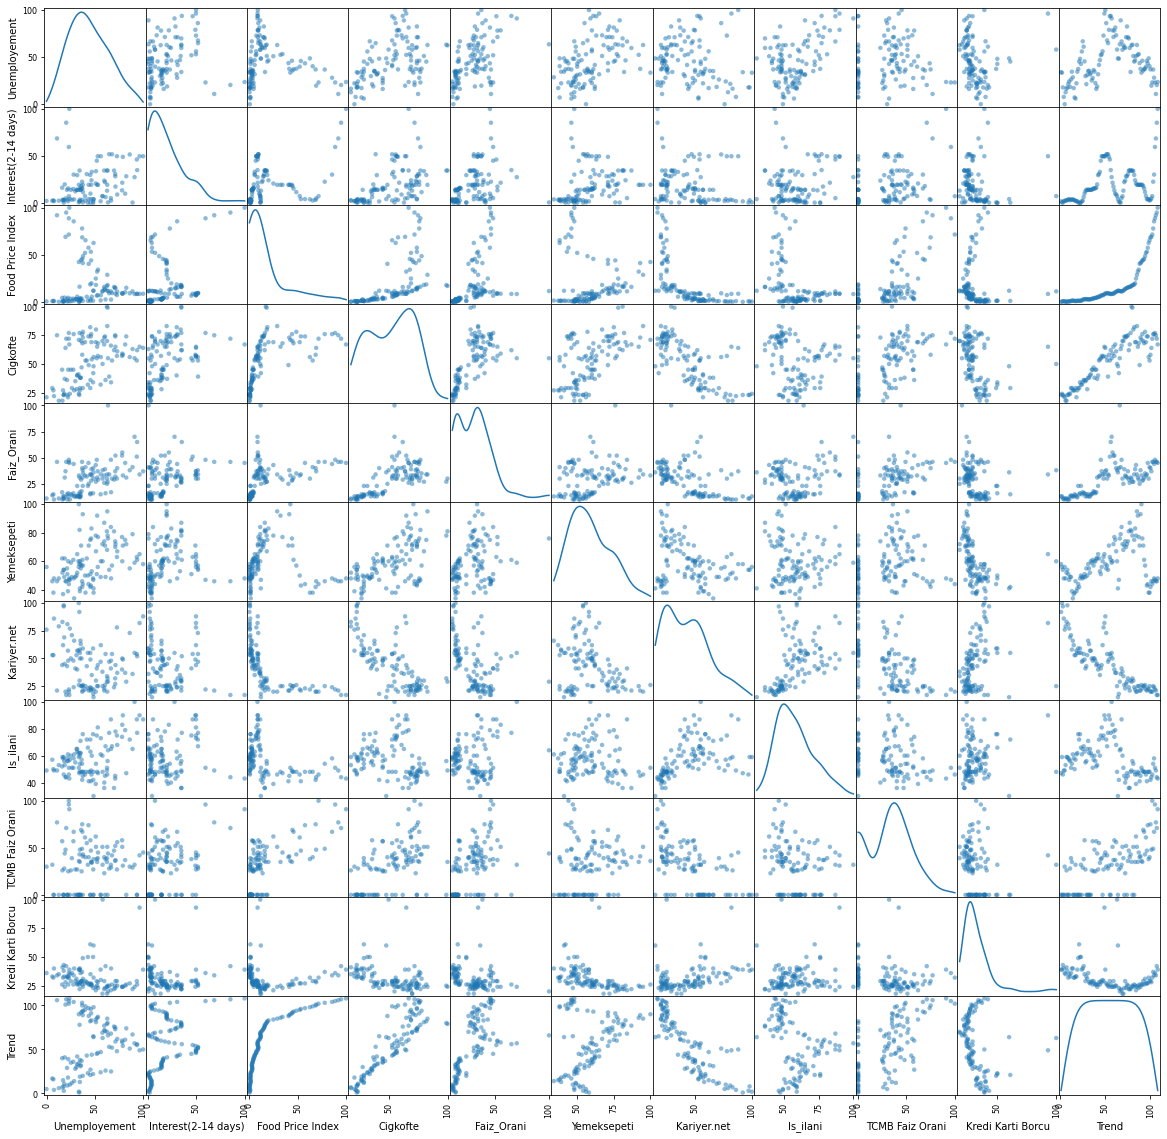

In [187]:
# To see the correlation between the columns with plots
pd.plotting.scatter_matrix(df, figsize=(20, 20), diagonal="kde", s = 80)

plt.show()

Some of the data seem to have a nonlinear relation. One example can be the trend and food CPI. Contrary, in some pairwise relations seems like there is not a relation like the commonly known distribution of a function. One example can be the "Ciğköfte" search data and "İş İlanı" search data.

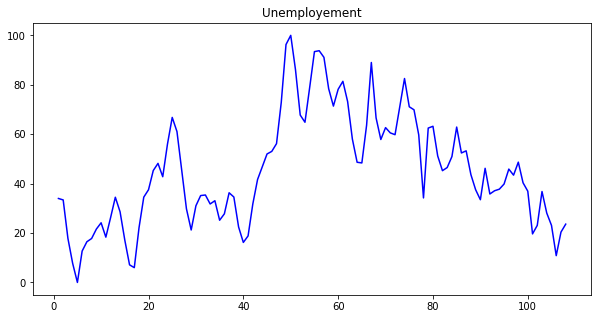

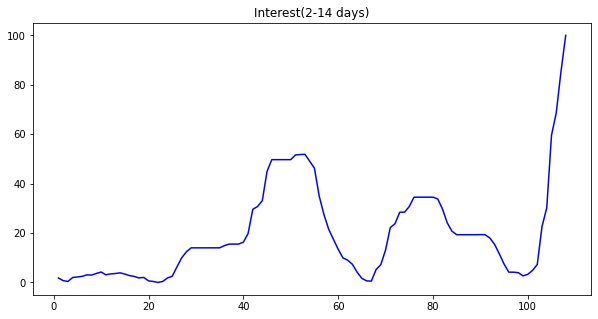

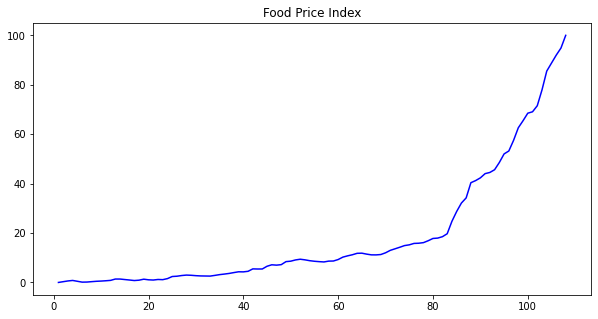

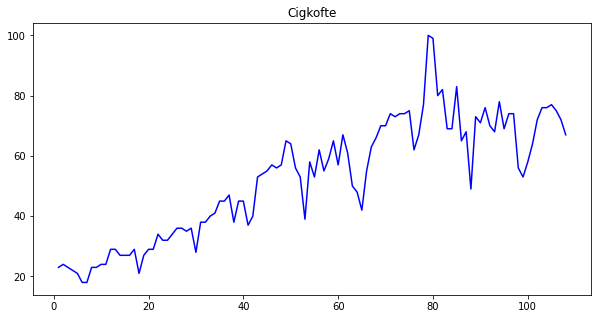

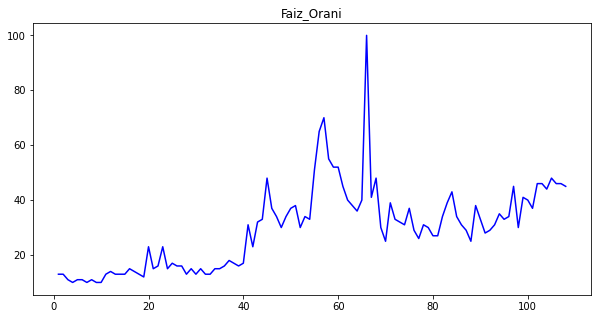

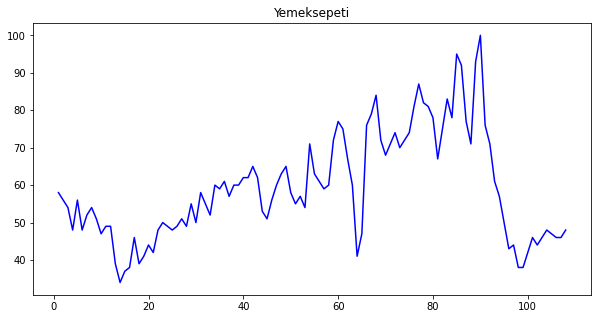

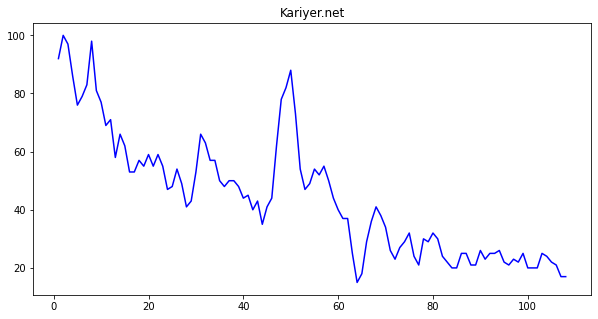

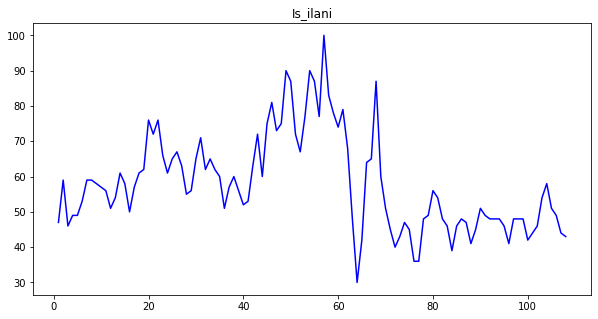

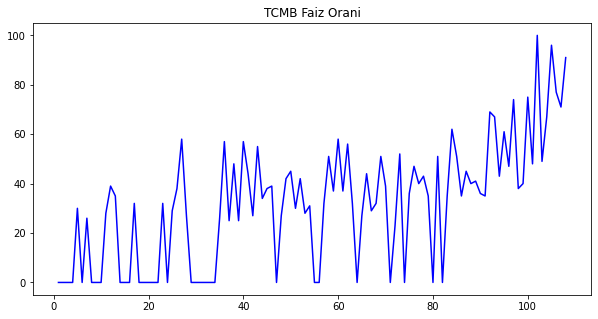

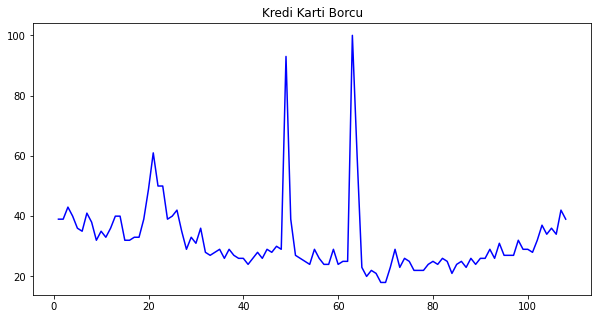

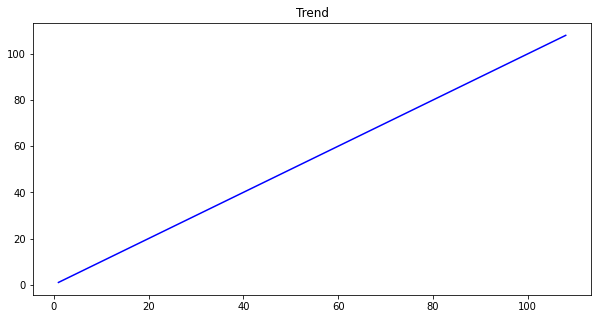

In [188]:
# Plot all of the data
for col in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df["Trend"], df[col], label=col, color="blue")
    plt.title(col)
    plt.show()

Expect the interest rate, most of the data is distributed like heartbeats with some trends. Since interest rate is an externally decided variable, this is expected.

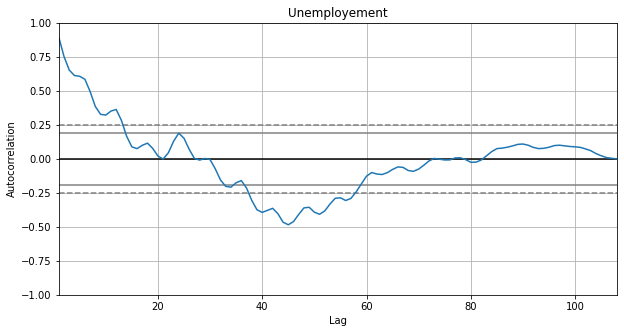

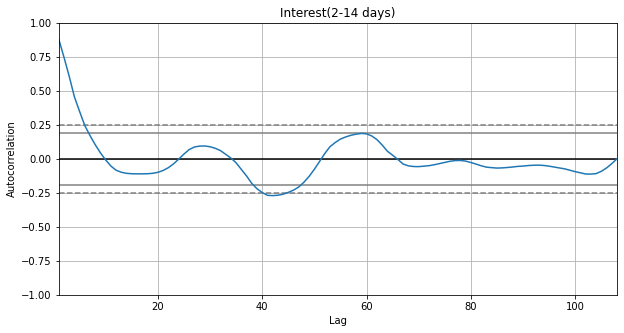

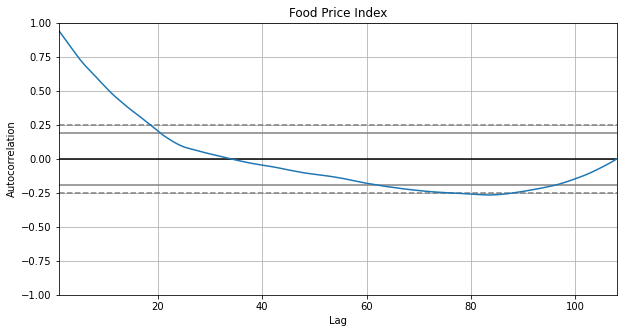

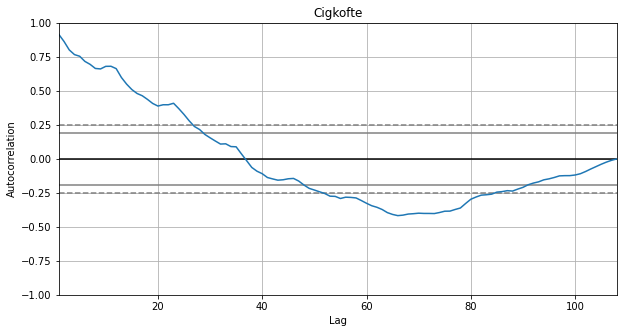

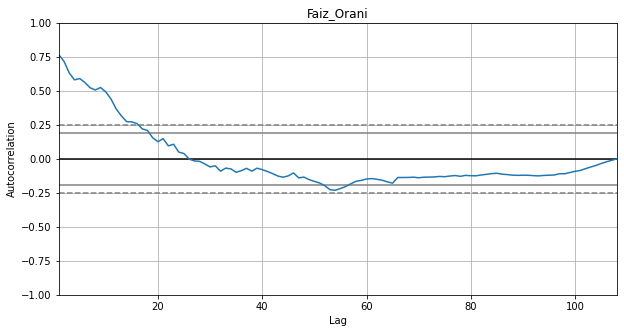

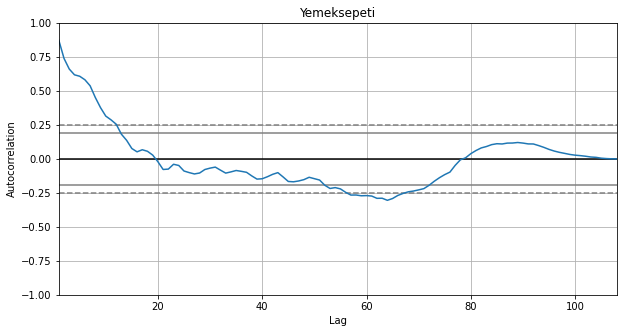

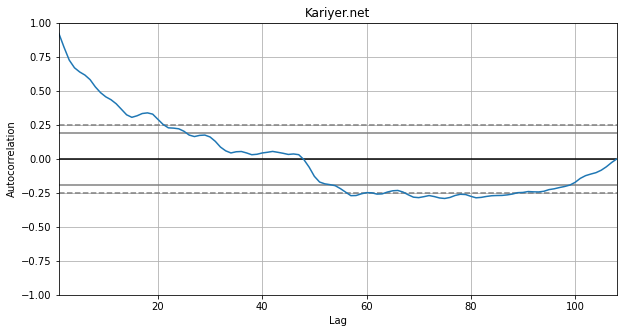

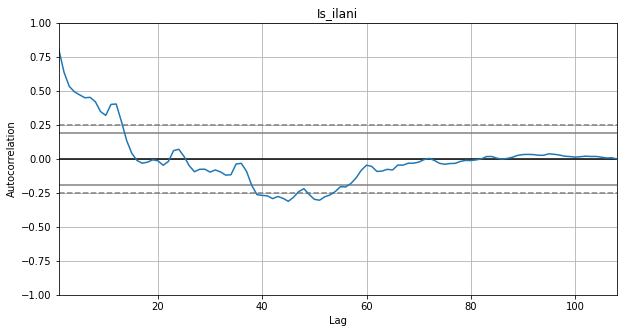

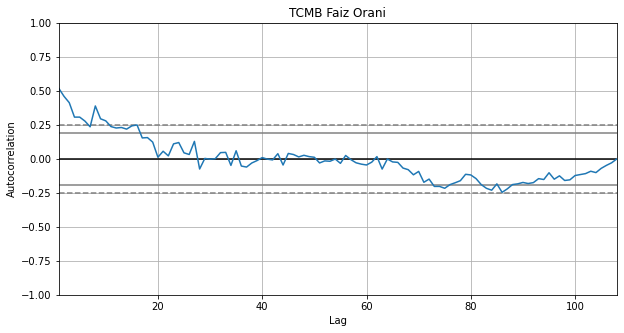

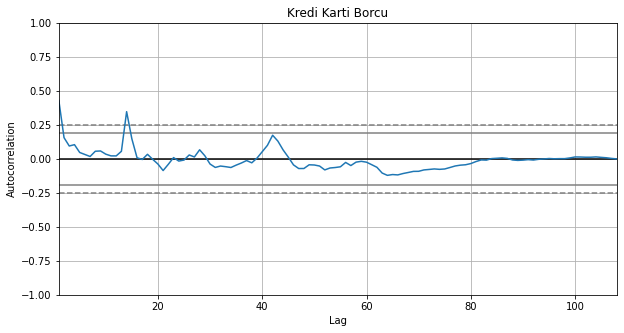

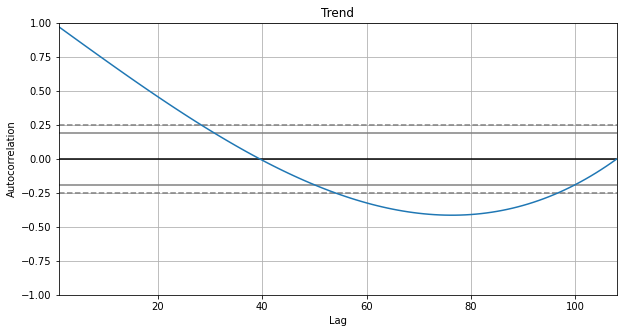

In [189]:
# Plot the autocorrelation of the data
for col in df.columns:
    plt.figure(figsize=(10, 5))
    pd.plotting.autocorrelation_plot(df[col])
    plt.title(col)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

### Model 1: Estimate Unemployement 

In [190]:
a = df.copy()

# Drop the columns which does not have a relation with the data in a sense
a.drop(["Faiz_Orani", "Cigkofte", "Yemeksepeti", "TCMB Faiz Orani"], axis=1, inplace=True)  

a.head()

,Unemployement,Interest(2-14 days),Food Price Index,Kariyer.net,Is_ilani,Kredi Karti Borcu,Trend
Date,,,,,,,
2015-01,33.983666,1.792224,0.000000,92,47,39,1
2015-02,33.393829,0.729040,0.305046,100,59,39,2
2015-03,17.831216,0.394897,0.604242,97,46,43,3
2015-04,7.713249,2.004860,0.806492,86,49,40,4
2015-05,0.000000,2.217497,0.468434,76,49,36,5


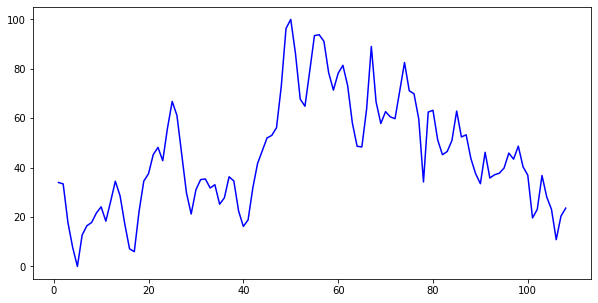

In [191]:
# Plot the response variable
plt.figure(figsize=(10, 5))
plt.plot(a["Trend"], a["Unemployement"], label="Unemployement", color="blue")
plt.show()

Start the model building with all of the data with linear relations.

In [192]:
a = sm.add_constant(a) # Intercept term
independent_set_1 = a[["const", "Trend", "Food Price Index", "Interest(2-14 days)", "Kredi Karti Borcu", "Kariyer.net", "Is_ilani"]]

lm = sm.OLS(a["Unemployement"], independent_set_1)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Unemployement   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     48.87
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           1.03e-27
Time:                        15:59:23   Log-Likelihood:                -416.36
No. Observations:                 108   AIC:                             846.7
Df Residuals:                     101   BIC:                             865.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -64.7842    

Adj. R-squared started with a high value, 0.729. It is a promising sign for the model.

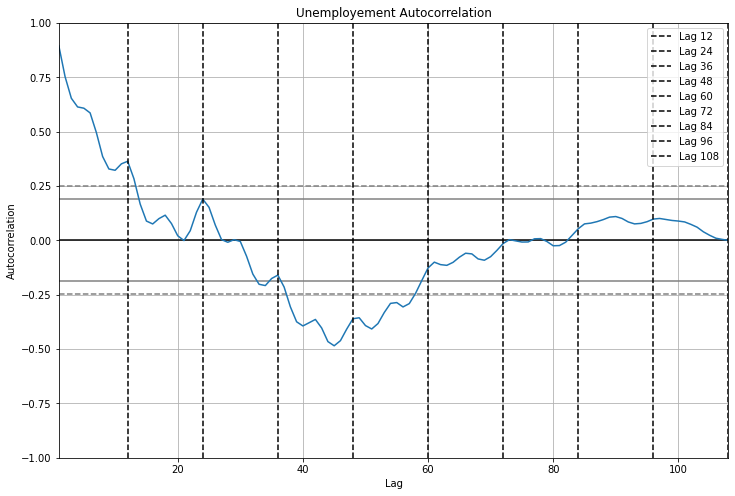

In [193]:
# Plot the autocorrelation
plt.figure(figsize=(12, 8))
pd.plotting.autocorrelation_plot(df["Unemployement"])
plt.title("Unemployement Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
# To show monthly autocorrelation
for i in range(12, 120, 12):
    plt.axvline(x=i, color='black', linestyle='--', label="Lag " + str(i))
plt.legend(loc="best")
plt.show()

Some of the lines intersected with the autocorrelation line at their local peaks but not in all of them. There doesn't seem to be a powerful autocorrelation between one year to another but let us try in a model. 

In [194]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November"]

# Create a column for each month
for m in months:
    a[m] = [1 if int(i.split("-")[1]) - 1 == months.index(m) else 0 for i in a.index]
    
a.head()

,const,Unemployement,Interest(2-14 days),Food Price Index,Kariyer.net,Is_ilani,Kredi Karti Borcu,Trend,January,February,March,April,May,June,July,August,September,October,November
Date,,,,,,,,,,,,,,,,,,,
2015-01,1.0,33.983666,1.792224,0.000000,92,47,39,1,1,0,0,0,0,0,0,0,0,0,0
2015-02,1.0,33.393829,0.729040,0.305046,100,59,39,2,0,1,0,0,0,0,0,0,0,0,0
2015-03,1.0,17.831216,0.394897,0.604242,97,46,43,3,0,0,1,0,0,0,0,0,0,0,0
2015-04,1.0,7.713249,2.004860,0.806492,86,49,40,4,0,0,0,1,0,0,0,0,0,0,0
2015-05,1.0,0.000000,2.217497,0.468434,76,49,36,5,0,0,0,0,1,0,0,0,0,0,0


Observe that there is not a variable for December since there is already a variable for the intercept.

In [195]:
 #  Model with monthly categorical variables
independent_set_2 = a[["const", "Trend", "Food Price Index", "Interest(2-14 days)", "Kredi Karti Borcu", "Kariyer.net", "Is_ilani"] + months]

lm = sm.OLS(a["Unemployement"], independent_set_2)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Unemployement   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     25.07
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           6.30e-27
Time:                        15:59:24   Log-Likelihood:                -395.58
No. Observations:                 108   AIC:                             827.2
Df Residuals:                      90   BIC:                             875.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -50.8821    

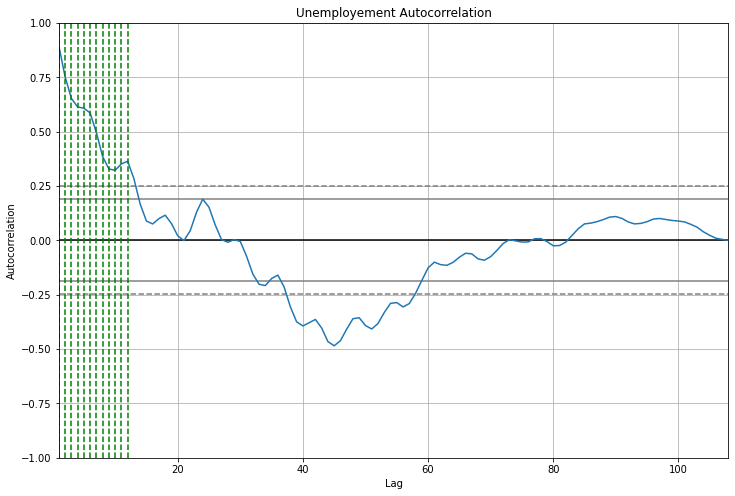

In [196]:
# Plot the autocorrelation
plt.figure(figsize=(12, 8))
pd.plotting.autocorrelation_plot(df["Unemployement"])
plt.title("Unemployement Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
# To show autocorrelation in a year
for i in range(13): 
    plt.axvline(x=i, color='g', linestyle='--')
plt.show()

As can be seen in the graph, unemployment data has a strong autocorrelation within a year. This situation also makes sense in real life. One major problem can be the differentiation between close days like the 31st of December and the 1st of January.

In [197]:
year = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]

# Create a column for each year
for y in year:
    a[y] = [1 if int(i.split("-")[0]) == int(y) else 0 for i in a.index]
    
a.head()

,const,Unemployement,Interest(2-14 days),Food Price Index,Kariyer.net,Is_ilani,Kredi Karti Borcu,Trend,January,February,...,November,2015,2016,2017,2018,2019,2020,2021,2022,2023
Date,,,,,,,,,,,,,,,,,,,,,
2015-01,1.0,33.983666,1.792224,0.000000,92,47,39,1,1,0,...,0,1,0,0,0,0,0,0,0,0
2015-02,1.0,33.393829,0.729040,0.305046,100,59,39,2,0,1,...,0,1,0,0,0,0,0,0,0,0
2015-03,1.0,17.831216,0.394897,0.604242,97,46,43,3,0,0,...,0,1,0,0,0,0,0,0,0,0
2015-04,1.0,7.713249,2.004860,0.806492,86,49,40,4,0,0,...,0,1,0,0,0,0,0,0,0,0
2015-05,1.0,0.000000,2.217497,0.468434,76,49,36,5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [198]:
# Model with monthly and yearly categorical variables
independent_set_3 = a[["const", "Trend", "Food Price Index", "Interest(2-14 days)", "Kredi Karti Borcu", "Kariyer.net", "Is_ilani"] + months + year]

lm = sm.OLS(a["Unemployement"], independent_set_3)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Unemployement   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     24.71
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           2.64e-28
Time:                        15:59:25   Log-Likelihood:                -376.64
No. Observations:                 108   AIC:                             803.3
Df Residuals:                      83   BIC:                             870.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -16.5662    

In [199]:
# Model after dropping the columns which are not significant
independent_set_4 = a[["const", "Trend", "Food Price Index", "Interest(2-14 days)", "Is_ilani"] + months + year]

lm = sm.OLS(a["Unemployement"], independent_set_4)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Unemployement   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     27.23
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           1.56e-29
Time:                        15:59:25   Log-Likelihood:                -377.29
No. Observations:                 108   AIC:                             800.6
Df Residuals:                      85   BIC:                             862.3
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -14.2163    

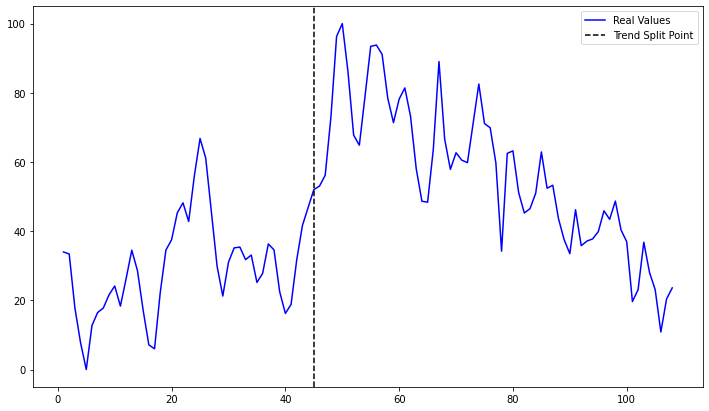

In [200]:
# Plot the data
plt.figure(figsize=(12, 7))
plt.plot(a["Trend"], a["Unemployement"], label="Real Values", color="blue")
plt.axvline(x = 45, color='black', linestyle='--', label="Trend Split Point") # to show the split point
plt.legend(loc="best")
plt.show()

From the graph, it is clear that there is a jump. To try one more approach in this model, add two separate trend variables.

In [201]:
a["Trend_1"] = list(range(1, 46)) + [0] * 63
a["Trend_2"] = [0] * 45 + list(range(46, len(a) + 1))

a.head()

,const,Unemployement,Interest(2-14 days),Food Price Index,Kariyer.net,Is_ilani,Kredi Karti Borcu,Trend,January,February,...,2016,2017,2018,2019,2020,2021,2022,2023,Trend_1,Trend_2
Date,,,,,,,,,,,,,,,,,,,,,
2015-01,1.0,33.983666,1.792224,0.000000,92,47,39,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2015-02,1.0,33.393829,0.729040,0.305046,100,59,39,2,0,1,...,0,0,0,0,0,0,0,0,2,0
2015-03,1.0,17.831216,0.394897,0.604242,97,46,43,3,0,0,...,0,0,0,0,0,0,0,0,3,0
2015-04,1.0,7.713249,2.004860,0.806492,86,49,40,4,0,0,...,0,0,0,0,0,0,0,0,4,0
2015-05,1.0,0.000000,2.217497,0.468434,76,49,36,5,0,0,...,0,0,0,0,0,0,0,0,5,0


In [202]:
# Model with splitted trend
independent_set_5 = a[["const", "Trend", "Food Price Index", "Interest(2-14 days)", "Is_ilani", "Trend_1", "Trend_2"] + months + year]

lm = sm.OLS(a["Unemployement"], independent_set_5)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Unemployement   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     27.05
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           1.41e-29
Time:                        15:59:26   Log-Likelihood:                -374.94
No. Observations:                 108   AIC:                             797.9
Df Residuals:                      84   BIC:                             862.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.1207    

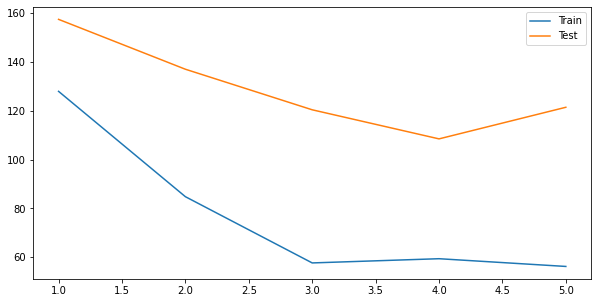

In [203]:
# Compare all of the models

independent_sets = [independent_set_1, independent_set_2, independent_set_3, independent_set_4, independent_set_5]
results_test = []
results_train = []

for set in independent_sets:
    train = []
    test = []
    for _ in range(300): # 300 times to get a more stable result
        X_train, X_test, y_train, y_test = train_test_split(set, a["Unemployement"], test_size=0.2) # split the data into train and test
        lm = sm.OLS(y_train, X_train)
        result = lm.fit()
        # MSE
        train.append(np.mean(result.resid ** 2))
        test.append(np.mean((result.predict(X_test) - y_test) ** 2))
        
    results_train.append(np.mean(train)) 
    results_test.append(np.mean(test))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), results_train, label="Train")
plt.plot(range(1, 6), results_test, label="Test")
plt.legend(loc="best")
plt.show()

In [204]:
best_set = independent_set_4.copy() # the best set is the one with the lowest test error to prevent overfitting

lm = sm.OLS(a["Unemployement"], best_set)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Unemployement   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     27.23
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           1.56e-29
Time:                        15:59:35   Log-Likelihood:                -377.29
No. Observations:                 108   AIC:                             800.6
Df Residuals:                      85   BIC:                             862.3
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -14.2163    

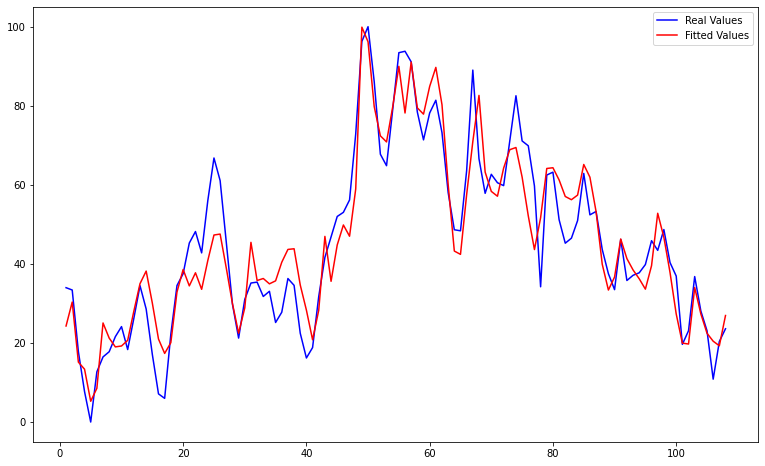

In [205]:
#Plot the fitted values and the real values
plt.figure(figsize=(13, 8))
plt.plot(a["Trend"], a["Unemployement"], label="Real Values", color="blue")
plt.plot(a["Trend"], result.fittedvalues, label="Fitted Values", color="red")
plt.legend(loc="best")
plt.show()

For most of the parts, the best model gives similar results compared to real ones however this level inspection is not enough. Linear regression's assumptions about residuals also need to be checked.

<AxesSubplot: title={'center': 'Residuals'}, ylabel='Density'>

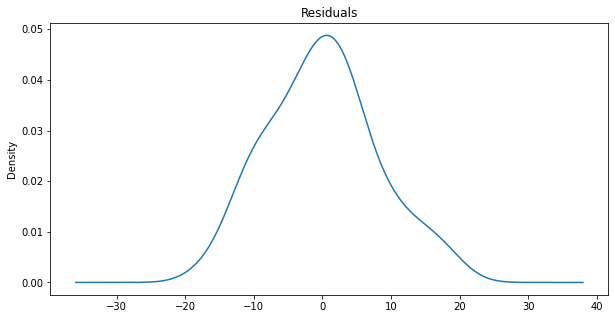

In [206]:
#Check normality of the residuals
result.resid.plot(kind="kde", title="Residuals", figsize=(10, 5))

As the first assumption states, residuals look like to distributed normally with mean 0 and constant variance.

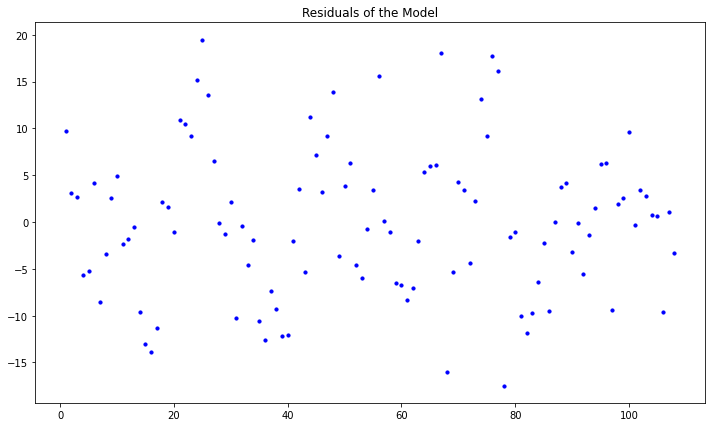

In [207]:
residual = result.resid

plt.figure(figsize = (12, 7))
plt.scatter(df["Trend"],residual, label = "Residual", color = "blue", s = 10)
plt.title("Residuals of the Model")

plt.show()

By the looks of this plot, there is not a clear autocorrelation between residuals of the best model.

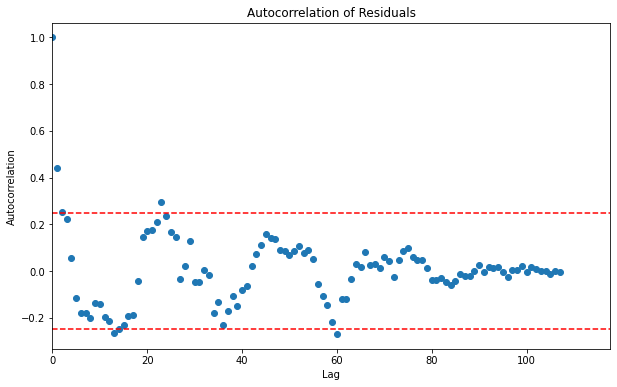

In [208]:
plt.figure(figsize=(10, 6))  
plt.acorr(residual, maxlags=len(residual)-1, usevlines = False, marker='o')
plt.axhline(y=0.25, color='red', linestyle='--') 
plt.axhline(y=-0.25, color='red', linestyle='--') 
plt.title("Autocorrelation of Residuals")
plt.xlim(0, )
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

From this graph, it can be seen that some values reached above the limit |0.25| autocorrelation. Also, there is a clear autocorrelation. Data is distributed like a sine/cosine wave. This result yields a big problem. It means that there is still a piece of information that should be in the model. Therefore, it is clear that this forecasting model will raise problems eventually.

In [209]:
# Delete variables 
del a, independent_set_1, independent_set_2, independent_set_3, independent_set_4, independent_set_5, best_set, lm, result, residual

### Model 2: Estimate Food Price Index

In [210]:
a = df.copy()

# Drop the columns which does not have a relation with the data in a sense
a.drop(["TCMB Faiz Orani", "Kredi Karti Borcu", "Is_ilani", "Kariyer.net", "Faiz_Orani"], axis=1, inplace=True)  

a.head()

,Unemployement,Interest(2-14 days),Food Price Index,Cigkofte,Yemeksepeti,Trend
Date,,,,,,
2015-01,33.983666,1.792224,0.000000,23,58,1
2015-02,33.393829,0.729040,0.305046,24,56,2
2015-03,17.831216,0.394897,0.604242,23,54,3
2015-04,7.713249,2.004860,0.806492,22,48,4
2015-05,0.000000,2.217497,0.468434,21,56,5


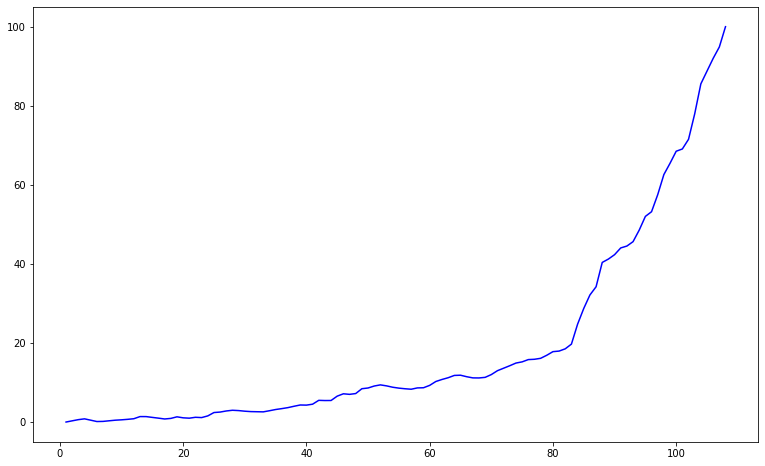

In [211]:
# Plot the response variable
plt.figure(figsize=(13, 8))
plt.plot(a["Trend"], a["Food Price Index"], color="blue")
plt.show()

In [212]:
a = sm.add_constant(a) # Intercept term

# Model with the columns which are related to the response variable by sense
independent_set_1 = a[["const", "Cigkofte", "Unemployement", "Interest(2-14 days)", "Trend", "Yemeksepeti"]]

lm = sm.OLS(a["Food Price Index"], independent_set_1)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Food Price Index   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     187.2
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           9.97e-50
Time:                        15:59:38   Log-Likelihood:                -374.50
No. Observations:                 108   AIC:                             761.0
Df Residuals:                     102   BIC:                             777.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  20.4840    

This model started with an adjusted R-squared value, of 0.897. This shows that regressors have an explanatory relationship at some level.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


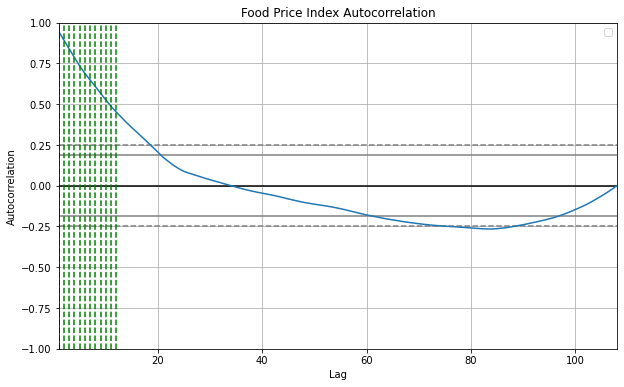

In [213]:
# Plot the autocorrelation
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(df["Food Price Index"])
plt.title("Food Price Index Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
# To show autocorrelation in yearly basis
for _ in range(13): 
    plt.axvline(x=_, color='g', linestyle='--')
plt.legend(loc="best")
plt.show()

On a yearly basis, data has high autocorrelation. Adding yearly categorical variables might help to increase the accuracy of the forecast.

In [214]:
year = ["2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"] # No 2023 because there is intercept

# Create a column for each year
for y in year:
    a[y] = [1 if int(i.split("-")[0]) == int(y) else 0 for i in a.index]
    
a.head()

,const,Unemployement,Interest(2-14 days),Food Price Index,Cigkofte,Yemeksepeti,Trend,2015,2016,2017,2018,2019,2020,2021,2022
Date,,,,,,,,,,,,,,,
2015-01,1.0,33.983666,1.792224,0.000000,23,58,1,1,0,0,0,0,0,0,0
2015-02,1.0,33.393829,0.729040,0.305046,24,56,2,1,0,0,0,0,0,0,0
2015-03,1.0,17.831216,0.394897,0.604242,23,54,3,1,0,0,0,0,0,0,0
2015-04,1.0,7.713249,2.004860,0.806492,22,48,4,1,0,0,0,0,0,0,0
2015-05,1.0,0.000000,2.217497,0.468434,21,56,5,1,0,0,0,0,0,0,0


In [215]:
# Model with yearly categorical variables
independent_set_2 = a[["const", "Cigkofte", "Unemployement", "Interest(2-14 days)", "Trend", "Yemeksepeti"] + year]

lm = sm.OLS(a["Food Price Index"], independent_set_2)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Food Price Index   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     480.6
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           7.83e-80
Time:                        15:59:39   Log-Likelihood:                -272.36
No. Observations:                 108   AIC:                             572.7
Df Residuals:                      94   BIC:                             610.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  23.3940    

In [216]:
# Model after dropping the columns which are not significant
independent_set_3 = a[["const", "Unemployement", "Interest(2-14 days)", "Trend", "Yemeksepeti"] + year]

lm = sm.OLS(a["Food Price Index"], independent_set_3)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Food Price Index   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     526.1
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           3.35e-81
Time:                        15:59:39   Log-Likelihood:                -272.37
No. Observations:                 108   AIC:                             570.7
Df Residuals:                      95   BIC:                             605.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  23.5571    

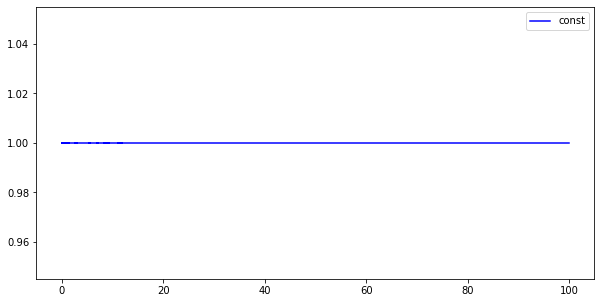

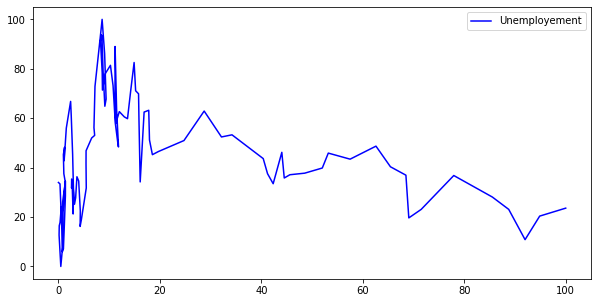

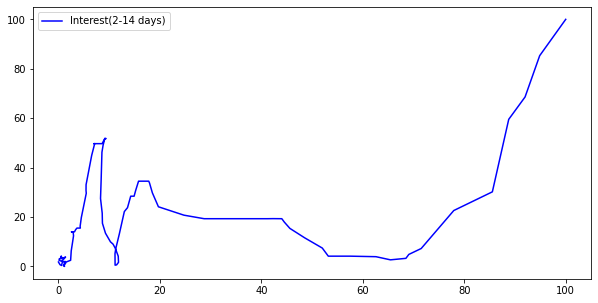

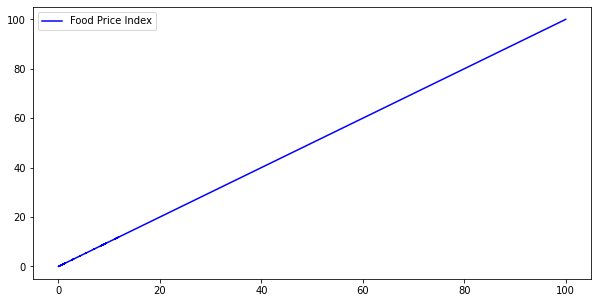

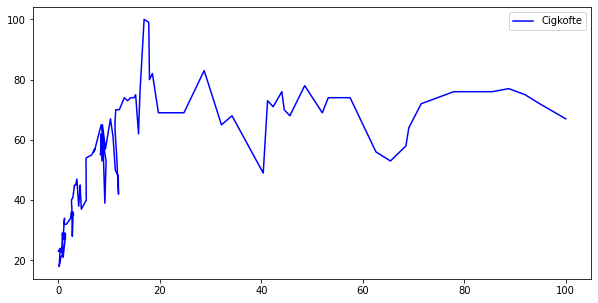

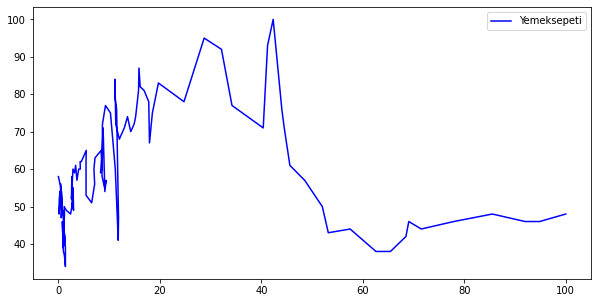

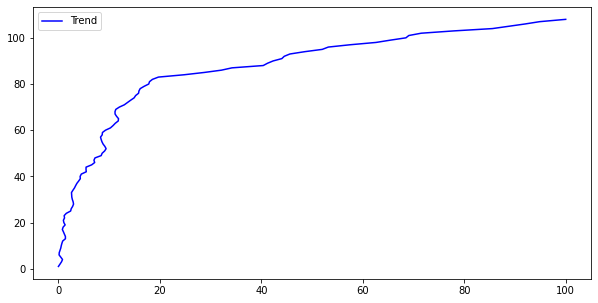

In [217]:
# To see relations between the data
for col in a:
    if col not in year:
        plt.figure(figsize=(10, 5))
        plt.plot(a["Food Price Index"], a[col], label=col, color="blue")
        plt.legend(loc="best")
        plt.show()

For most of the parts, there doesn't seem to be a clear nonlinear relation but it is best to try some variables.

In [218]:
a["e^Trend"] = np.exp(-a["Trend"])
a["Interest(2-14 days)_2"] = [0] * 38 + [np.exp(-i) for i in a["Interest(2-14 days)"][:70]]
a["Cigkofte_2"] = [np.exp(-i) for i in a["Cigkofte"][:18]] + [0] * len(a["Cigkofte"][18:])
a["Cigkofte_3"] = [0] * len(a["Cigkofte"][:65]) + [1 for i in a["Cigkofte"][65:]] 
a["Trend_2"] = [0] * 81 + [1 for i in a["Trend"][81:]]

In [219]:
# Model after adding new variables
independent_set_4 = a[["const", "Unemployement", "Interest(2-14 days)", "Trend", "Yemeksepeti", "e^Trend", "Interest(2-14 days)_2", "Cigkofte_2", "Cigkofte_3", "Trend_2"] + year]

lm = sm.OLS(a["Food Price Index"], independent_set_4)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Food Price Index   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     461.9
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           8.92e-80
Time:                        15:59:41   Log-Likelihood:                -257.86
No. Observations:                 108   AIC:                             551.7
Df Residuals:                      90   BIC:                             600.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    28.47

In [220]:
# Model after dropping the columns which are not significant
independent_set_5 = a[["const", "Unemployement", "Interest(2-14 days)", "Trend", "Yemeksepeti", "e^Trend", "Interest(2-14 days)_2", "Cigkofte_3", "Trend_2"] + year]

lm = sm.OLS(a["Food Price Index"], independent_set_5)
result = lm.fit()

In [221]:
# Model with splitted trend
independent_set_6 = a[["const", "Unemployement", "Interest(2-14 days)", "Trend", "Yemeksepeti", "e^Trend"] + year]

lm = sm.OLS(a["Food Price Index"], independent_set_4)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Food Price Index   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     461.9
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           8.92e-80
Time:                        15:59:41   Log-Likelihood:                -257.86
No. Observations:                 108   AIC:                             551.7
Df Residuals:                      90   BIC:                             600.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    28.47

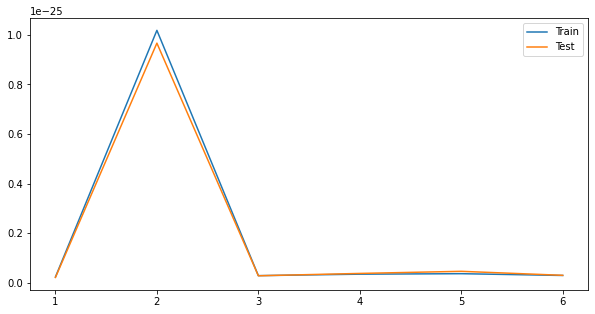

In [222]:
# Compare all of the models
independent_sets = [independent_set_1, independent_set_2, independent_set_3, independent_set_4, independent_set_5, independent_set_6]
results_test = []
results_train = []

for set in independent_sets:
    train = []
    test = []
    for _ in range(300): # 300 times to get a more stable result
        X_train, X_test, y_train, y_test = train_test_split(set, a["Unemployement"], test_size=0.2) # split the data into train and test
        lm = sm.OLS(y_train, X_train)
        result = lm.fit()
        #MSE
        train.append(np.mean(result.resid ** 2))
        test.append(np.mean((result.predict(X_test) - y_test) ** 2))
        
    results_train.append(np.mean(train)) 
    results_test.append(np.mean(test))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 7), results_train, label="Train")
plt.plot(range(1, 7), results_test, label="Test")
plt.legend(loc="best")
plt.show()

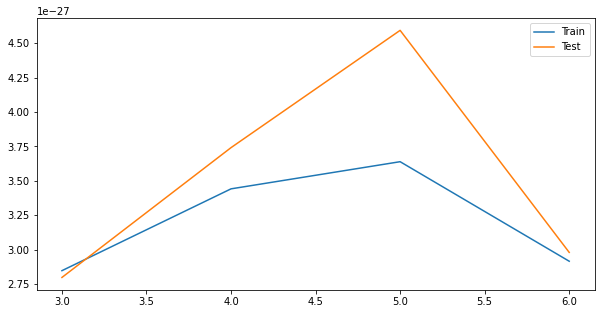

In [223]:
plt.figure(figsize=(10, 5))
plt.plot(range(3, 7), results_train[2:], label="Train")
plt.plot(range(3, 7), results_test[2:], label="Test")
plt.legend(loc="best")
plt.show()

Model 3 is the best among six models when mean squared error is used as a measure. 

In [224]:
best_set = independent_set_3.copy()

lm = sm.OLS(a["Food Price Index"], best_set)
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Food Price Index   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     526.1
Date:                Sat, 23 Mar 2024   Prob (F-statistic):           3.35e-81
Time:                        15:59:50   Log-Likelihood:                -272.37
No. Observations:                 108   AIC:                             570.7
Df Residuals:                      95   BIC:                             605.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  23.5571    

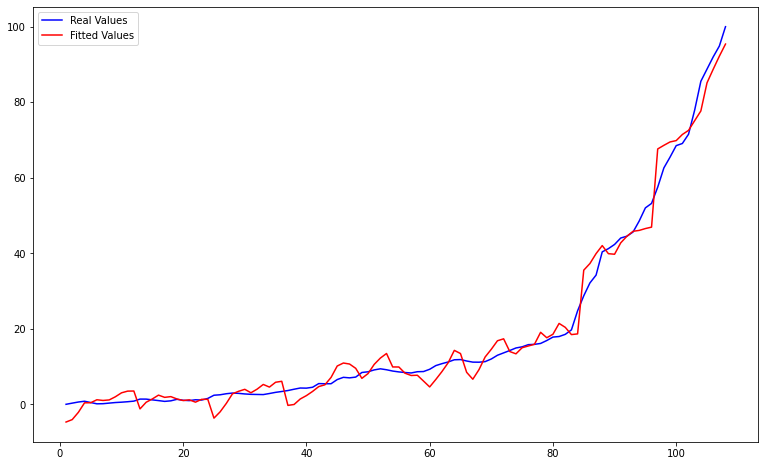

In [225]:
# Plot the fitted values and the real values
plt.figure(figsize=(13, 8))
plt.plot(a["Trend"], a["Food Price Index"], label="Real Values", color="blue")
plt.plot(a["Trend"], result.fittedvalues, label="Fitted Values", color="red")
plt.legend(loc="best")
plt.show()

<AxesSubplot: title={'center': 'Residuals'}, ylabel='Density'>

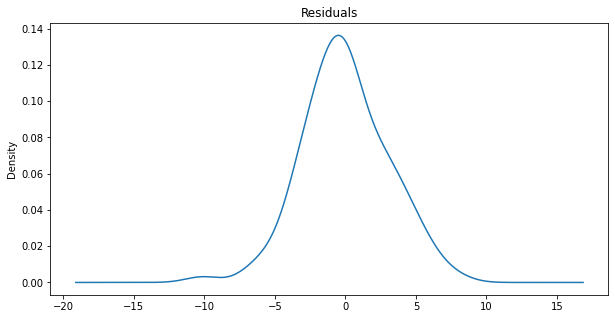

In [226]:
# Check normality of the residuals
result.resid.plot(kind="kde", title="Residuals", figsize=(10, 5))

Majority of the plots show that residuals are distributed normally with mean 0 and constant variance.

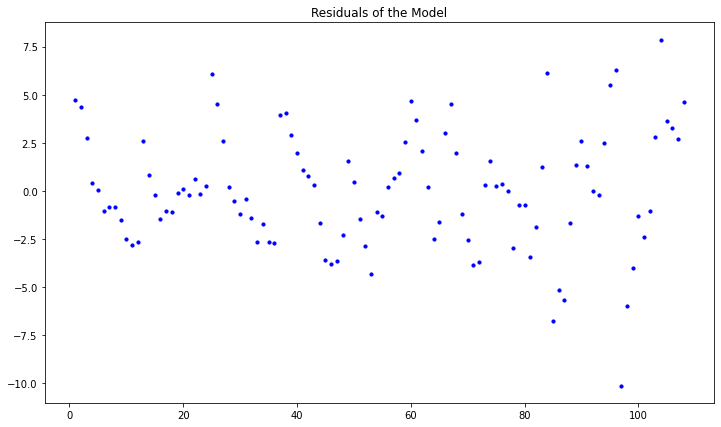

In [227]:
# Check autocorrelation of the residuals
residual = result.resid

plt.figure(figsize = (12, 7))
plt.scatter(df["Trend"],residual, label = "Residual", color = "blue", s = 10)
plt.title("Residuals of the Model")

plt.show()

There seems to be a clear autocorrelation between residuals of the best model. Variance increases as the time goes on. This is a problem that should be solved.

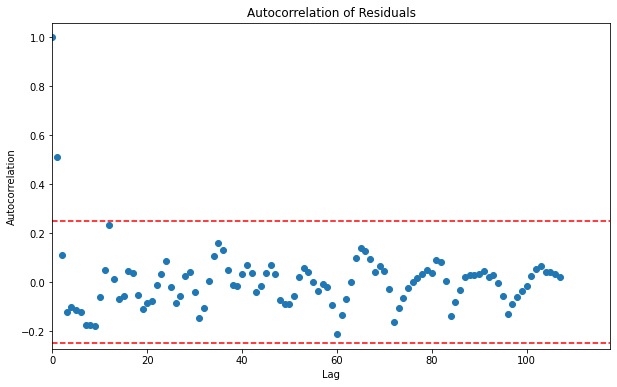

In [228]:
plt.figure(figsize=(10, 6))  
plt.acorr(residual, maxlags=len(residual)-1, usevlines = False, marker='o')
plt.axhline(y=0.25, color='red', linestyle='--') 
plt.axhline(y=-0.25, color='red', linestyle='--') 
plt.title("Autocorrelation of Residuals")
plt.xlim(0, )
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

From this plot, also it can be seen that residuals have a clear autocorrelation. In the long run, this will cause a problem. Even with the fact that the model has a high adjusted R-squared value and a great fit. There is still information that needs to be added.

In [229]:
# Delete variables
del a, independent_set_1, independent_set_2, independent_set_3, independent_set_4, independent_set_5, independent_set_6,lm, result, residual, best_set, independent_sets

### Model 3: Estimate Interest(2-14 days)

In [230]:
a = df.copy()

# Drop the columns which does not have a relation with the data in a sense
a.drop(["Yemeksepeti", "Kariyer.net", "Is_ilani", "Cigkofte"], axis=1, inplace=True)  

a.head()

,Unemployement,Interest(2-14 days),Food Price Index,Faiz_Orani,TCMB Faiz Orani,Kredi Karti Borcu,Trend
Date,,,,,,,
2015-01,33.983666,1.792224,0.000000,13,0,39,1
2015-02,33.393829,0.729040,0.305046,13,0,39,2
2015-03,17.831216,0.394897,0.604242,11,0,43,3
2015-04,7.713249,2.004860,0.806492,10,0,40,4
2015-05,0.000000,2.217497,0.468434,11,30,36,5


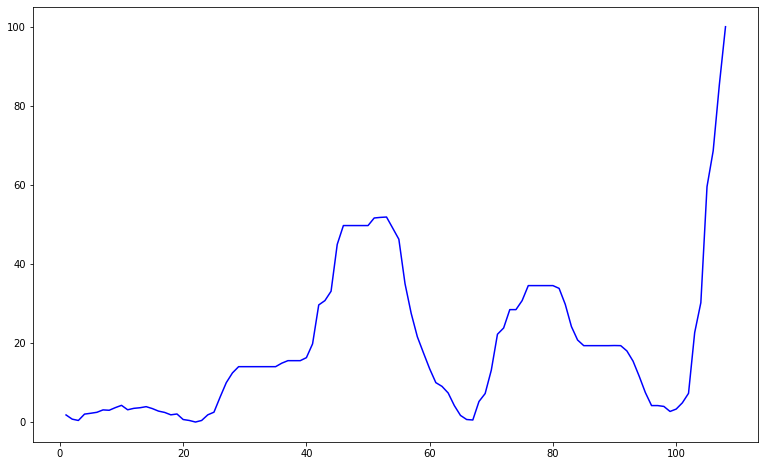

In [231]:
# Plot the response variable
plt.figure(figsize=(13, 8))
plt.plot(a["Trend"], a["Interest(2-14 days)"], color="blue")
plt.show()

In [232]:
a = sm.add_constant(a) # Intercept term

# Model with the columns which are related to the response variable by sense
independent_set_1 = a[["const", "Faiz_Orani", "Unemployement", "Food Price Index", "Trend", "TCMB Faiz Orani", "Kredi Karti Borcu"]]

lm = sm.OLS(a["Interest(2-14 days)"], independent_set_1)
result = lm.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Interest(2-14 days)   R-squared:                       0.265
Model:                             OLS   Adj. R-squared:                  0.222
Method:                  Least Squares   F-statistic:                     6.075
Date:                 Sat, 23 Mar 2024   Prob (F-statistic):           1.85e-05
Time:                         15:59:52   Log-Likelihood:                -455.11
No. Observations:                  108   AIC:                             924.2
Df Residuals:                      101   BIC:                             943.0
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.8648

The first model has a terrible adjusted R-square value, which is 0.222. Also, it seems that regressors do not fit with the response variable well. This might be about the choice of the regressors but also in a country where interest rate policy is controversial, this situation is expected. To increase the accuracy of this model, real-life dates where the policy rate had changed are added.

In [233]:
split_points = ["2015-01","2016-11","2018-04", "2018-07", "2019-07", "2020-02", "2020-10", "2022-07", "2023-05"] # Split points

for i in range(1, len(split_points) - 1):
    a["TCMB_" + str(i)] = [0] * len(a)
    
for i in range(1, len(split_points)):
    a["TCMB_" + str(i)] = [1 if split_points[i-1] <= index and index < split_points[i] else 0 for index in a.index]

a["TCMB_" + str(len(split_points))] = [1 if split_points[-1] <= index else 0 for index in a.index]

tcmb_lst = ["TCMB_" + str(i) for i in range(1, len(split_points))] # TCMB columns

In [234]:
# Model with splitted TCMB data
independent_set_2 = a[["const", "Faiz_Orani", "Unemployement", "Food Price Index", "Trend", "TCMB Faiz Orani", "Kredi Karti Borcu"] + tcmb_lst]

lm = sm.OLS(a["Interest(2-14 days)"], independent_set_2)
result = lm.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Interest(2-14 days)   R-squared:                       0.701
Model:                             OLS   Adj. R-squared:                  0.656
Method:                  Least Squares   F-statistic:                     15.58
Date:                 Sat, 23 Mar 2024   Prob (F-statistic):           1.10e-18
Time:                         15:59:52   Log-Likelihood:                -406.53
No. Observations:                  108   AIC:                             843.1
Df Residuals:                       93   BIC:                             883.3
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                16.5544

The model's accuracy and R-squared value have increased significantly. Let us inspect the data by plotting to see if these split points are good enough.

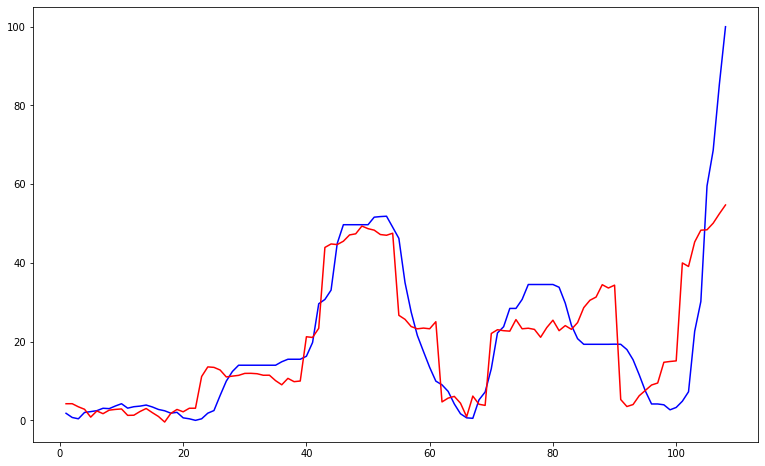

In [235]:
plt.figure(figsize=(13, 8))
plt.plot(a["Trend"], a["Interest(2-14 days)"], label="Real Values", color="blue")
plt.plot(a["Trend"], result.fittedvalues, label="Fitted Values", color="red")

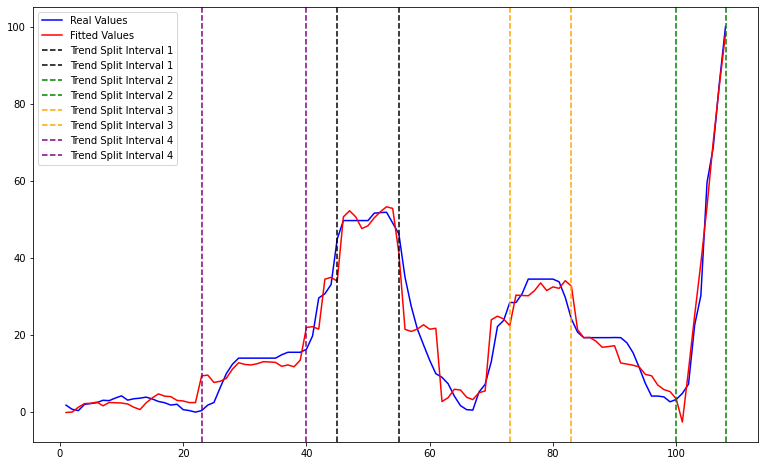

In [249]:
plt.figure(figsize=(13, 8))
plt.plot(a["Trend"], a["Interest(2-14 days)"], label="Real Values", color="blue")
plt.plot(a["Trend"], result.fittedvalues, label="Fitted Values", color="red")

plt.axvline(x=45, color="black", linestyle="--", label="Trend Split Interval 1")
plt.axvline(x=55, color="black", linestyle="--", label="Trend Split Interval 1")

plt.axvline(x=100, color="green", linestyle="--", label="Trend Split Interval 2")
plt.axvline(x=len(a), color="green", linestyle="--", label="Trend Split Interval 2")

plt.axvline(x=73, color="orange", linestyle="--", label="Trend Split Interval 3")
plt.axvline(x=83, color="orange", linestyle="--", label="Trend Split Interval 3")

plt.axvline(x=23, color="purple", linestyle="--", label="Trend Split Interval 4")
plt.axvline(x=40, color="purple", linestyle="--", label="Trend Split Interval 4")

plt.legend(loc="best")
plt.show()

In this plot, it can be seen that the split points are chosen well. But there is still room for improvement.

In [252]:
# New additions
a["Trend_2"] = [0] * 100 + list(range(1, len(a["Trend"][100:]) + 1))
a["Trend_3"] = [0] * 45 + list(range(1, len(a["Trend"][45:55]) + 1)) + [0]* 53
a["Trend_4"] = [0] * 73 + list(range(1, len(a["Trend"][73:83]) + 1)) + [0]* 25
a["Trend_5"] = [0] * 23 + list(range(1, len(a["Trend"][23:40]) + 1)) + [0]* 68

trend_lst = ["Trend_2", "Trend_3", "Trend_4", "Trend_5"] # Trend columns

In [253]:
# Model with new data
independent_set_3 = a[["const", "Faiz_Orani", "Unemployement", "Food Price Index", "Trend", "TCMB Faiz Orani", "Kredi Karti Borcu"] + tcmb_lst + trend_lst]

lm = sm.OLS(a["Interest(2-14 days)"], independent_set_3)
result = lm.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Interest(2-14 days)   R-squared:                       0.947
Model:                             OLS   Adj. R-squared:                  0.936
Method:                  Least Squares   F-statistic:                     87.97
Date:                 Sat, 23 Mar 2024   Prob (F-statistic):           1.08e-48
Time:                         16:05:37   Log-Likelihood:                -313.34
No. Observations:                  108   AIC:                             664.7
Df Residuals:                       89   BIC:                             715.6
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4518

In [254]:
# Model after dropping the columns which are not significant
independent_set_4 = a[["const", "Faiz_Orani", "Food Price Index", "Trend", "TCMB Faiz Orani", "Trend_2", "Trend_3", "Trend_4"] + tcmb_lst + trend_lst]

lm = sm.OLS(a["Interest(2-14 days)"], independent_set_4)
result = lm.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Interest(2-14 days)   R-squared:                       0.947
Model:                             OLS   Adj. R-squared:                  0.937
Method:                  Least Squares   F-statistic:                     100.8
Date:                 Sat, 23 Mar 2024   Prob (F-statistic):           1.25e-50
Time:                         16:06:16   Log-Likelihood:                -313.53
No. Observations:                  108   AIC:                             661.1
Df Residuals:                       91   BIC:                             706.7
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0471   

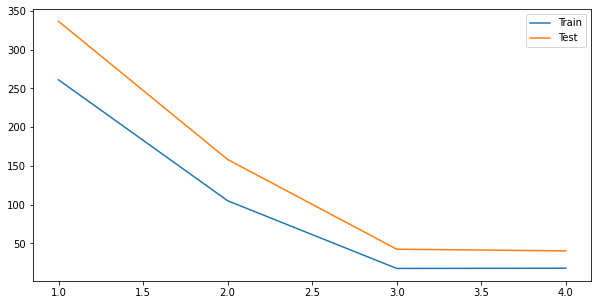

In [255]:
# Compare all of the models
independent_sets = [independent_set_1, independent_set_2, independent_set_3, independent_set_4]
results_test = []
results_train = []

for set in independent_sets:
    train = []
    test = []
    for _ in range(300): # 300 times to get a more stable result
        X_train, X_test, y_train, y_test = train_test_split(set, a["Interest(2-14 days)"], test_size=0.2) # split the data into train and test
        lm = sm.OLS(y_train, X_train)
        result = lm.fit()
        #MSE
        train.append(np.mean(result.resid ** 2))
        test.append(np.mean((result.predict(X_test) - y_test) ** 2))
        
    results_train.append(np.mean(train)) 
    results_test.append(np.mean(test))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 5), results_train, label="Train")
plt.plot(range(1, 5), results_test, label="Test")
plt.legend(loc="best")
plt.show()

After the comparison, clearly model 3 and model 4 have the lowest mean squared error values for both train data and test data. Between these two models, model 4 is chosen as the best model because it has fewer variables compared to model 3. With this approach, overfitting can be avoided if there is any.

In [242]:
best_set = independent_set_4.copy()

lm = sm.OLS(a["Interest(2-14 days)"], best_set)
result = lm.fit()
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Interest(2-14 days)   R-squared:                       0.955
Model:                             OLS   Adj. R-squared:                  0.946
Method:                  Least Squares   F-statistic:                     112.1
Date:                 Sat, 23 Mar 2024   Prob (F-statistic):           6.92e-53
Time:                         16:00:00   Log-Likelihood:                -304.42
No. Observations:                  108   AIC:                             644.8
Df Residuals:                       90   BIC:                             693.1
Df Model:                           17                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.5108

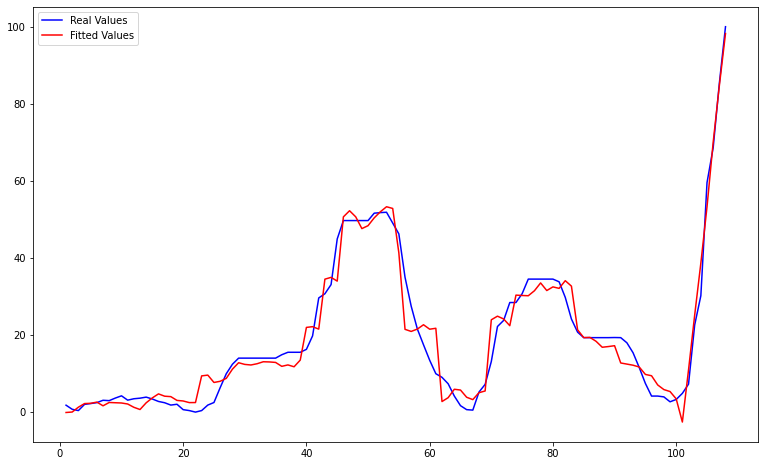

In [243]:
plt.figure(figsize=(13, 8))
plt.plot(a["Trend"], a["Interest(2-14 days)"], label="Real Values", color="blue")
plt.plot(a["Trend"], result.fittedvalues, label="Fitted Values", color="red")
plt.legend(loc="best")
plt.show()

<AxesSubplot: title={'center': 'Residuals'}, ylabel='Density'>

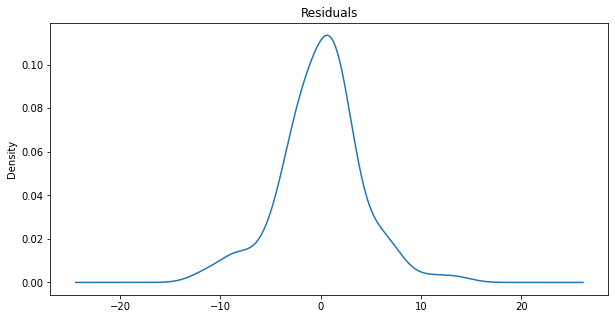

In [244]:
result.resid.plot(kind="kde", title="Residuals", figsize=(10, 5))

Residuals seems to have constant variance and mean 0 as desired.

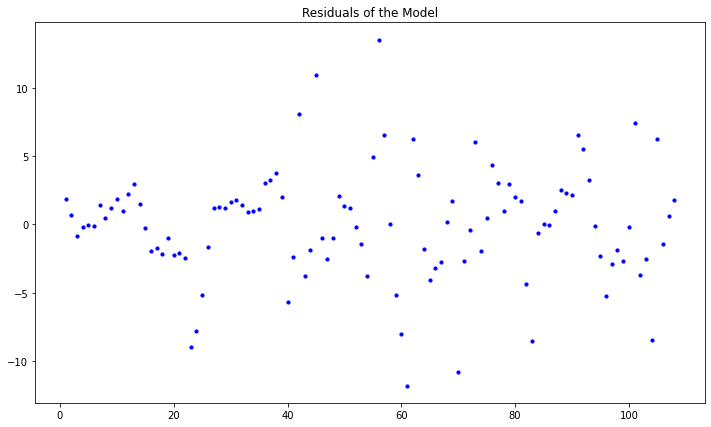

In [245]:
residual = result.resid

plt.figure(figsize = (12, 7))
plt.scatter(df["Trend"],residual, label = "Residual", color = "blue", s = 10)
plt.title("Residuals of the Model")

plt.show()

At start of the residuals, it looks like there is a autocorrelation at some level but after that part, there doesn't seem to be a autocorrelation.

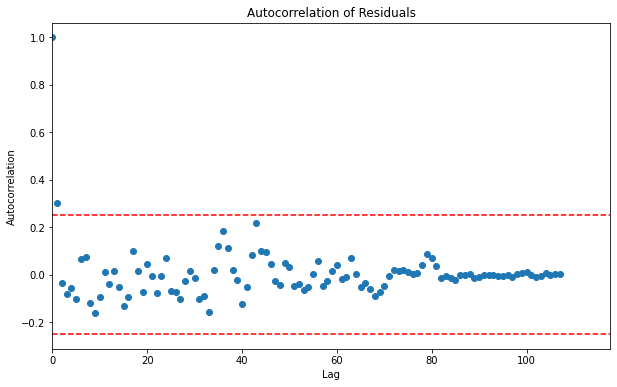

In [246]:
plt.figure(figsize=(10, 6))  
plt.acorr(residual, maxlags=len(residual)-1, usevlines = False, marker='o')
plt.axhline(y=0.25, color='red', linestyle='--') 
plt.axhline(y=-0.25, color='red', linestyle='--') 
plt.title("Autocorrelation of Residuals")
plt.xlim(0, )
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

Previous observation also can be seen here

# Conclusion